# <center>How to use the von-Karman-PostProcess module ?</center>
## <center>By Nikita Allaglo</center>
### <center>16/07/2023</center>

# 1. Building a database

The SFEMaNS data I based all my work upon is located in the following directory on **Lab-IA**:

<code>/mnt/beegfs/projects/sfemans_ai/data_hugues_Re_6000_anticontra</code>

We thereafter show how to construct the database with the Database class. <br>
<ins>This section's blocks should only be executed **once**.</ins>

In [1]:
from vkpp import Database

source = '/mnt/beegfs/projects/sfemans_ai/data_hugues_Re_6000_anticontra/'       # SFEMaNS full data
sfx = 'tfin_374p8/'                                                              # eventual subdirs ('' default)
target = '/mnt/beegfs/projects/sfemans_ai/connectors/'                           # name of connectors dir
M = 255                                                                          # number of fourier modes
dic = 'data_hugues.pkl'                                                          # name of the created dictionnary
db = Database(source, sfx=sfx, target=target, M=M, dic=dic, space='phys')        # space 'phys' by default

mkdir: cannot create directory ‘/mnt/beegfs/projects/sfemans_ai/connectors/’: File exists


phys field D001_DR added successfuly (for the first time) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field D001_Dnu added successfuly (for the first time) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field D001_He added successfuly (for the first time) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field D001_penal added successfuly (for the first time) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field D002_DR added successfuly (for the first time) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field D002_Dnu added successfuly (for the first time) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field Du_2 added successfuly (for the first time) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field Du_l1 added successfuly (for the first time) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field omega added successfuly (for 

### If the source data has many sub dirs (sfx argument), complete the database as follows:

In [2]:
sfxs = ['tfin_385p3', 'tfin_395p3', 'tfin_406p3']
for sfx in sfxs:
    print('######################################################################')
    print(sfx)
    db.make(sfx)

######################################################################
tfin_385p3
Fields will be added in /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
Already present fields : ['D001_DR' 'D001_Dnu' 'D001_He' 'D001_penal' 'D002_DR' 'D002_Dnu' 'Du_2'
 'Du_l1' 'omega' 'u' 'v_weight' 'vr_axis' 'vz_axis']
phys field D001_DR added successfuly (as a suite) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field D001_Dnu added successfuly (as a suite) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field D001_He added successfuly (as a suite) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field D001_penal added successfuly (as a suite) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field D002_DR added successfuly (as a suite) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys field D002_Dnu added successfuly (as a suite) to /mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl
phys fi

# 2. Post-Processing bird's eye view
The database yields the following data structure:
$$(1,T,P,N),$$
$T$ being the number of snapshots, $P$ the number of planes and $N$ the number of points per mesh (1 can finally be replaced with the number of intrinsic components). **You must make sure to perpetuate the same structure throughout your post-processing. Always slice with $\texttt{A[:, [i], :, :]}$ instead of $\texttt{A[:, i, :, :]}$.**

## 2.1. Basic usage
The following section provides simple examples on how to use the Stats class.<br>
The present directory is provided with two submission scripts: 
- <code>jupyter_cpu.sh</code>; using 7 CPU-cores (14 threads) under 150 GB of CPU RAM.
- <code>jupyter_gpu.sh</code>; using 1 GPU (node 1-5) + 7 CPU-cores (14 threads) under 48 GB of GDDR6 RAM.

The notebook automatically checks if you're using CPU or GPU ressources; the cell blocks are executable regardless of the ressources.
Just make sure the branch you're on is coherent with the resources you were allocated. The following commands might be helpful for git:
```console
$ git branch -a
```
to check the available branches and 
```console
$ git checkout BRANCH_NAME
```
to switch between branches.

### 2.1.1. Setting the Post-Processing module

In [1]:
import numpy as np
import dask.array as da

# Verifying the device
try:
    import cupy as cp
    cp.array([0])
    gpu=True
    from vkcupp import Stats
except:
    gpu=False
    from vkpp import Stats
    
# Setting the Stats object
db_path = '/mnt/beegfs/projects/sfemans_ai/connectors/data_hugues.pkl'
pp = Stats(db_path, 'full')   # 'full' specifies that no points are to be excluded in the statistics
pp.dims

(1, 28, 509, 732018)

In [2]:
data = pp.db
list(data.keys())

['vr_axis',
 'vz_axis',
 'v_weight',
 'D001_DR',
 'D001_Dnu',
 'D001_He',
 'D001_penal',
 'D002_DR',
 'D002_Dnu',
 'Du_2',
 'Du_l1',
 'omega',
 'u']

### 2.1.2. Parallel-loading with Dask

In [3]:
w = data['omega']['field']
w

dask.array<getitem, shape=(3, 28, 509, 732018), dtype=float64, chunksize=(1, 1, 1, 732018), chunktype=numpy.ndarray>

In [4]:
w[:, [0], :, :]

dask.array<getitem, shape=(3, 1, 509, 732018), dtype=float64, chunksize=(1, 1, 1, 732018), chunktype=numpy.ndarray>

As you can see, <code>w</code> is still delayed no matter the operation applied to it. Because of bad experience,  regardless of the branch, <ins>prior to any calculation</ins>, you should ALWAYS load the data on the RAM instead of piling delayed dask operations or converting from Dask to CuPy. Piling delayed operations can quickly give rise to memory problems or performance bottlenecks. <br>
On the other hand, the loading can be made more stable by rechunking your data properly to the resources at hand.

In [5]:
w = w.rechunk((3, 1, pp.dims[2], pp.dims[3]//14))
w_0 = w[:, [0], :, :].compute()

if gpu:
    # transferring to CUDA
    w_0 = cp.array(w_0, copy=False)

w_0.shape

(3, 1, 509, 732018)

### 2.1.3. Norm
For any more-than-one-component field $\boldsymbol{X}$ defined **anywhere**, returns $\sqrt{\sum_i X_i^2}$.

In [6]:
w_norm = pp.norm(w_0)
w_norm.shape

(1, 1, 509, 732018)

### 2.1.4. Averages

In [7]:
w_avg = pp.mean(w_norm, type='both')
w_avg
# since here there is no temporal axis, type='both' is the same as type='spatial'

array(11.31052761)

### 2.1.5. PDF

In [8]:
bins = 1000
w_pdf, w_edges = pp.pdf(w_norm/w_avg, bins=bins)
# you can specify a range with range=[field_min, field_max]
# by default it computes the real min and max of the fields

(0.0, 5.0)

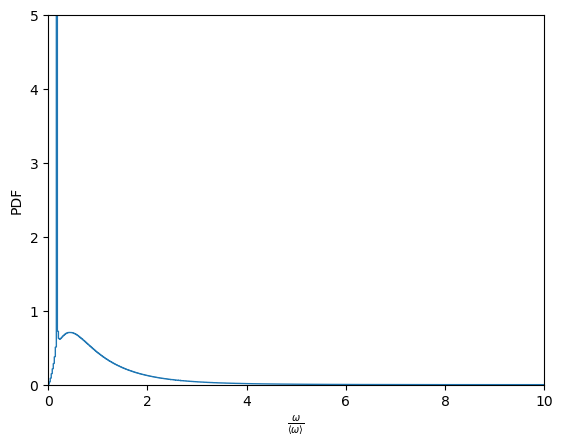

In [9]:
# Plotting
import matplotlib.pyplot as plt

if gpu:
    plt.stairs(w_pdf.get(), w_edges.get()) # transferring back to the CPU
else:
    plt.stairs(w_pdf, w_edges)
    
# plotting params
plt.xlabel(r'$\frac{\omega}{\langle\omega\rangle}$')
plt.ylabel(r'PDF')
plt.xlim(0, 10)
plt.ylim(0, 5)

### 2.1.6. Joint PDF

In [10]:
# Loading second field
Du = data['Du_2']['field'].rechunk((1, 1, pp.dims[2], pp.dims[3]//14))
Du_0 = Du[:, [0], :, :].compute()

if gpu:
    # transferring to CUDA
    Du_0 = cp.array(Du_0, copy=False)

In [11]:
epsilon = 0.045

Du_w, [Du_edges, w_edges] = pp.joint_pdf(Du_0/epsilon, w_norm/w_avg, bins=bins, log=False, save='JOINT_DuVSw.dat')
# log=True directly returns log10(2DHistogram)
# you can specify the ranges with ranges=[[field1_min, field1_max], [field2_min, field2_max]]

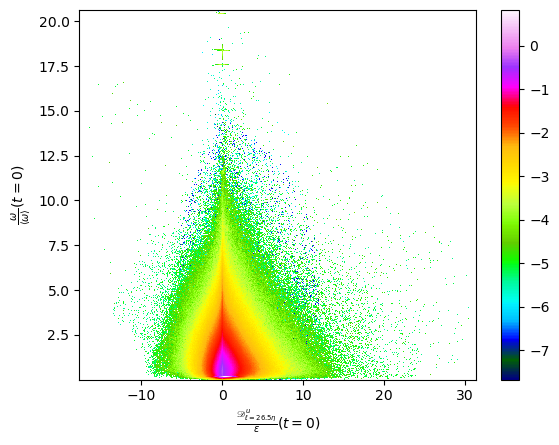

In [12]:
# Plotting

if gpu:
    X, Y = np.meshgrid(Du_edges.get(), w_edges.get())
    fp = plt.pcolormesh(X, Y, cp.log10(Du_w).get())
else:
    X, Y = np.meshgrid(Du_edges, w_edges)
    fp = plt.pcolormesh(X, Y, np.log10(Du_w))
    
# plotting params
plt.xlabel(r'$\frac{\mathscr{D}^u_{\ell=26.5\eta}}{\epsilon}(t=0)$')
plt.ylabel(r'$\frac{\omega}{\langle\omega\rangle}(t=0)$')
plt.set_cmap('gist_ncar')
plt.colorbar(fp)

If you reached this point **under the GPU version**, we suggest you to open a terminal on the node you're running (you can do so directly in jupyter: open back your jupyter file-browser and under *new*, select *Terminal*). Now type:
```console
$ nvidia-smi
```
You should now check your running Process in the Processes section. The memory usage should be close to 47-48 GB. The used GPU (nodes 1-5) have 48 GB of GDDR6 RAM. We now must manually free the memory.

In [13]:
if gpu:
    del w_0, w_norm, Du_w          
    cp._default_memory_pool.free_all_blocks() # deleting the 'ghosts'

### 2.1.7. Loading Joint PDF from file

In [14]:
if gpu:
    Du_w = cp.fromfile('JOINT_DuVSw.dat')
else:
    Du_w = np.fromfile('JOINT_DuVSw.dat')

Du_w = pp.load_reshaped(Du_w, bins)
Du_w.shape

(1000, 1000)

### 2.1.8. Extract PDF from Joint PDF

In [15]:
ranges = [[Du_edges[0], Du_edges[-1]], [w_edges[0], w_edges[-1]]]

Du_pdf = pp.extract_pdf(Du_w, 0, ranges)

Text(0, 0.5, 'PDF')

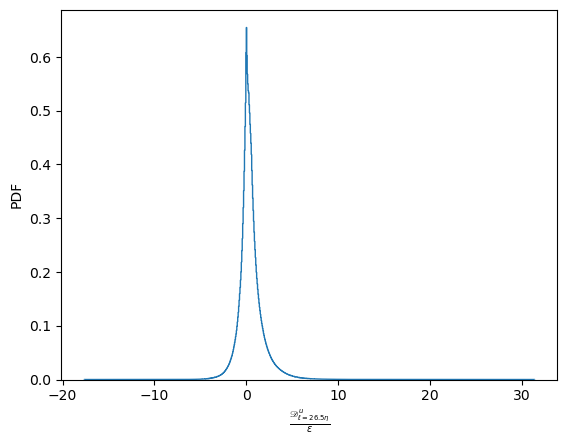

In [16]:
# Plotting

if gpu:
    plt.stairs(Du_pdf.get(), Du_edges.get()) # transferring back to the CPU
else:
    plt.stairs(Du_pdf, Du_edges)
    
# plotting params
plt.xlabel(r'$\frac{\mathscr{D}^u_{\ell=26.5\eta}}{\epsilon}$')
plt.ylabel(r'PDF')

### 2.1.9. Conditional average

In [17]:
w_given_Du = pp.conditional_avg(Du_w, 0, bins=bins, ranges=ranges)
Du_given_w = pp.conditional_avg(Du_w, 1, bins=bins, ranges=ranges)

(0.0, 10.0)

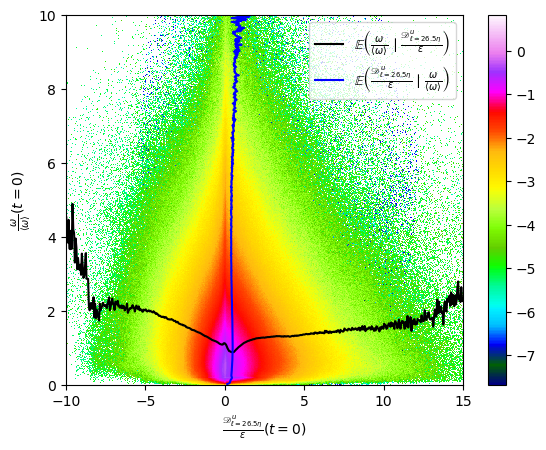

In [ ]:
# Plotting
%matplotlib inline
# midpoint of each bin
ech_w = pp.mid_points(w_edges)
ech_Du = pp.mid_points(Du_edges)

# plot labels
xplot = r'$\mathbb{E}\left(\frac{\omega}{\langle\omega\rangle}\mid\frac{\mathscr{D}^u_{\ell=26.5\eta}}{\epsilon}\right)$'
yplot = r'$\mathbb{E}\left(\frac{\mathscr{D}^u_{\ell=26.5\eta}}{\epsilon}\mid\frac{\omega}{\langle\omega\rangle}\right)$'

if gpu:
    # joint pdf
    fp = plt.pcolormesh(X, Y, cp.log10(Du_w).get())
    # conditional avgs
    plt.plot(ech_Du, w_given_Du.get(), 'k-', ms=0.1, label=xplot)
    plt.plot(Du_given_w.get(), ech_w, 'b-', ms=0.1, label=yplot)
else:
    # joint pdf
    fp = plt.pcolormesh(X, Y, np.log10(Du_w))
    # conditional avgs
    plt.plot(ech_Du, w_given_Du, 'k-', ms=0.1, label=xplot)
    plt.plot(Du_given_w, ech_w, 'b-', ms=0.1, label=yplot)

# plotting params
plt.xlabel(r'$\frac{\mathscr{D}^u_{\ell=26.5\eta}}{\epsilon}(t=0)$')
plt.ylabel(r'$\frac{\omega}{\langle\omega\rangle}(t=0)$')
plt.set_cmap('gist_ncar')
plt.colorbar(fp)
plt.legend(loc=0)
plt.xlim(-10, 15)
plt.ylim(0, 10)

### 2.1.10. Correlations

In [20]:
corr_Du_w = pp.correlations(Du_w, bins=bins, ranges=ranges, log=True)

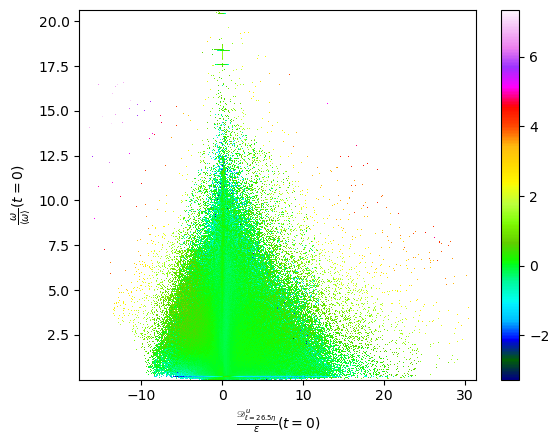

In [21]:
# Plotting
if gpu:
    fp = plt.pcolormesh(X, Y, corr_Du_w.get())
else:
    fp = plt.pcolormesh(X, Y, corr_Du_w)
    
# plotting params
plt.xlabel(r'$\frac{\mathscr{D}^u_{\ell=26.5\eta}}{\epsilon}(t=0)$')
plt.ylabel(r'$\frac{\omega}{\langle\omega\rangle}(t=0)$')
plt.set_cmap('gist_ncar')
plt.colorbar(fp)

For visualization improvements, please refer to section 2.1.12.

### 2.1.11. Statistics sub-spaces 
At initialization, we used the option <code>stat='full'</code>. This enables the post-processing to take ALL points into account. We can specify other type of post-processing.

#### 2.1.11.1.  Bulk/Interior
<code>stat='bulk'</code> selects all points with $r\leq 0.1$ and $|z|\leq 0.1$. <br>
<code>stat='interior'</code> selects all points with $|z|\leq 0.69$.<br>
If you want to change the type after initialization you can just do as follows:

In [22]:
pp.set_stats('bulk')

All future calculations will now only take into account relevant points. You don't need to specify anything else (all the 2.1. section remains valid).

#### 2.1.11.2. Penal
<code>stat='penal'</code> modifies SFEMaNS penalization field to be a real indicator function. $\texttt{penal}$ returns 1 if $\texttt{penal} > 0.8$ and 0 otherwise. When activating the penalized postprocessing, because it is close to impossible to effectively load a full field, you always need to specify a slice.

In [23]:
pp.set_stats('penal')
pp.penal

dask.array<rechunk-merge, shape=(1, 28, 509, 732018), dtype=float64, chunksize=(1, 1, 509, 52287), chunktype=numpy.ndarray>

As you can see, penal is a full delayed array. If you want to launch a calc, the code will raise an error and tell you to provide a slice.

In [24]:
pp.mean(Du_0, type='both')

ValueError: You are probably trying to deploy workloads withfully penalized fields. 
Prior to your calculation, please make sure toself.set_penal(slice(None), slice(None), slice(None), slice(None))to effectively load penal.

In [25]:
s = slice(None)
pp.set_penal(s, [0], s, s)
# s1, s2, s3, s4 are the slices to make on D, T, P, N axis
pp.penal

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]]])

In [26]:
pp.mean(Du_0, type='both')

array(0.01931352)

Once the penalization is effectively set, all the 2.1 section remains valid (you don't need to specify anything else).

### 2.1.12. Visualization tips
In case you want to use the blue-to-red rainbow colormap used in Faller *et al.*, since it is not natively implemented in matplotlib; use instead the following:

In [27]:
from matplotlib.colors import LinearSegmentedColormap
N = 256
colors = [(0,0,1,0.75), (0,0,0.5), (0,1,1), (0,0.5,0), (1,1,0), (1,0.5,0), (0.5,0,0), (1,0,0,0.75)]
cmap_name = 'btr_rainbow'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=N)
plt.register_cmap(cmap=cmap)

/tmp/ipykernel_14125/2388232321.py:6: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=cmap)


Finally, vanilla correlations colorbars are most of times useless: the correlations' scope is so large that rare events (rare in the sense that very few bins captured them) skew the colorbar's gradient (look at figure in section 2.1.10 for example). When post-processing on 1 target, it won't be a problem because you can manually set the <code>vmin/vmax</code> arguments after visualizing a plot. When working with 20+ targets, it will consume quite some time to check each plot and manually fix the colorbar limit. Moreover, it is better if all the figures return the same 0-correlation. <br>
As a consequence, I wrote a code that automatically finds convenient colorbar limits. 

In [29]:
from matplotlib.colors import TwoSlopeNorm

if gpu:
    corr = corr_Du_w.get()
corr[corr == -np.inf] = np.nan

cuts = np.arange(np.nanmax(corr), np.nanmin(corr), -0.5)               # partitioned colorbar range
n_bins = []
for i, cut in enumerate(cuts[:-1]):
    print('###################################################################')
    print('Interval [%f, %f]' % (cut, cuts[i+1]))
    # number of bins captured in each division
    n = corr[np.logical_and(corr<=cut, corr>=cuts[i+1])].shape[0] 
    n_bins.append(n)
    print(n_bins[i])

n_bins = np.array(n_bins)
cutoff = bins//4
# vmax
for i, bins in enumerate(n_bins):
    if bins > cutoff:
        vmax = cuts[i]
        print(vmax)
        break
# vmin
for i, bins in enumerate(n_bins[::-1]):
    if bins > cutoff:
        vmin = cuts[::-1][i]
        print(vmin)
        break
        
divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

###################################################################
Interval [7.349791, 6.849791]
16
###################################################################
Interval [6.849791, 6.349791]
25
###################################################################
Interval [6.349791, 5.849791]
30
###################################################################
Interval [5.849791, 5.349791]
28
###################################################################
Interval [5.349791, 4.849791]
56
###################################################################
Interval [4.849791, 4.349791]
90
###################################################################
Interval [4.349791, 3.849791]
183
###################################################################
Interval [3.849791, 3.349791]
380
###################################################################
Interval [3.349791, 2.849791]
584
###################################################################
Interval [2.849791, 

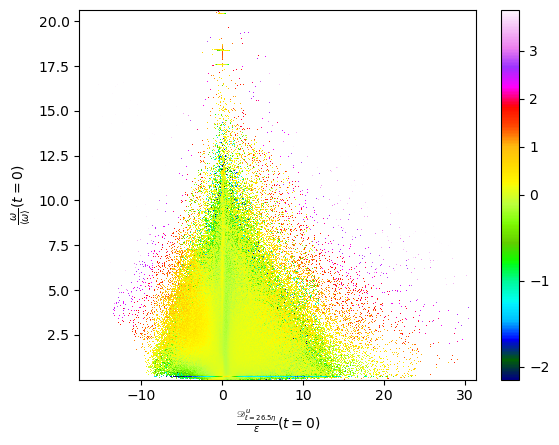

In [30]:
# Plotting
fp = plt.pcolormesh(X, Y, corr, cmap='gist_ncar', norm=divnorm)
    
# plotting params
plt.xlabel(r'$\frac{\mathscr{D}^u_{\ell=26.5\eta}}{\epsilon}(t=0)$')
plt.ylabel(r'$\frac{\omega}{\langle\omega\rangle}(t=0)$')

plt.colorbar(fp)

## 2.2. Real Post-Processing (full-fields)

Now that you know basic usage of the module, you can guess yourself that it won't really apply to *real* post-processing where we rather deal with fields much bigger in size. In this section, we will not really explain the principles of the memory schedulers (mainly *Divide-and-conquer algorithms*); we will instead give some case studies relevant to my internship. Because the computations are quite long (typically > 1h), we will not provide any executable code-block in the present section. Instead, we will reference the appropriate example in the <code>jobs_examples</code> directory.

### 2.2.1. Full-$\left(\mathscr{D}^u,\omega\right)$ ranges/averages computations
As I explained in my report, prior to a "real" calculation, you must compute some global parameters which are inputs of the stats-calcs. The <code>miscs</code> directory yields scripts enabling the user to get those. More precisely, the <code>ranges.py</code> and <code>avgs.py</code> scripts compute the ranges and averages for $\mathscr{D}^u$ and $\omega$ for each type of statistic (bulk, interior, penal and full) by restructuring the data. If you want to execute the scripts, just (in the case of ranges)

```console
$ sbatch ranges.sh
```

The averages and ranges for each statistic and each field are now saved in <code>ranges.pkl</code> and <code>avgs.pkl</code>. They will be used in the next sections.

### 2.2.2. Full-$\left(\mathscr{D}^u,\omega\right)$ joint PDFs computations
Just like in the previous section, we wrote a general array-like script <code>joints.py</code> computing the joint PDF for $\mathscr{D}^u$ and $\omega$ for each type of statistic (bulk, interior, penal and full) by restructuring the data. Please see the <code>joints</code> directory. If you want to execute the scripts, proceed as follows:
1. ```console
   $ sh make_tree.sh
   ```
   
   This bash script makes the following tree-structure:
   ```
    joints
    │   joints.py
    │   joints.sh
    │   make_tree.sh
    └───Du_l1
    │   └───bulk
    │   │   └───logs
    │   │
    │   └───interior
    │   │   └───logs
    │   │
    │   └───penal
    │   │   └───logs
    │   │
    │   └───full
    │       └───logs
    └───Du_2
         ⋮
    ```
   
1. ```console
   $ sbatch joints.sh
   ```
   
   4$\times$2 jobs (4 being the number of statistics and 2 the number of fields pairs) will be launched. 
   
The joint PDF of the recombined-data is saved accordingly to the tree-structure.

### 2.2.3. Full-$\left(\mathscr{D}^u,\omega\right)$ statistics plotting
You will find in the <code>plotting</code> directory a general script loading + plotting all the computed joint PDF: <code>plot.py</code>. You can just
```console
$ sbatch plot.sh
```
to get all the joints + correlations figures accordingly to the <code>joints</code> tree-structure.

### 2.2.4. Generalizations

In case you want to deploy specific workloads, I give you some ideas on how you can modify the provided scripts:
- change the <code>make_tree.sh</code> file to be specific to your fields/types of statistics. In case you want to deploy +20 workloads, you might want to make the tree directly in <code>joints.py</code> (use for example <code>itertools</code> to generate all possible pairs of fields existing in the flow...)
- the <code>misc</code> scripts will work regardless of the nature of the field (3D or 1D)
- for computations as much as loading codes, <ins>always think to make extreme-general scripts (independant of the fields, the stats, etc.) and take advantages of Slurm *job arrays*</ins>
- for the plotting, you should first plot *vanilla* graphs and only then renormalize them properly (axis limits/values, colorbars gradients, etc). Then incorporate them in your general script to be compatible with job arrays
- go back to the basic usage section (**2.1**) when you have doubt on how to natively use the post-processing module